In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from collections import Counter
from enum import IntEnum
from sklearn.ensemble import HistGradientBoostingRegressor, HistGradientBoostingClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import r2_score, root_mean_squared_error, mean_absolute_error, mean_squared_error, accuracy_score, classification_report
from xgboost import XGBClassifier, XGBRFClassifier
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline


In [2]:
# READING DATA

attributes_bmi = {
    "WEIGHTLBTC_A": "weight", #pounds
    "HEIGHTTC_A": "height", #inches
    "BMICAT_A": "bmi_group",
    "PREGNOW_A": "pregnant",
}

attributes = {
    "WEIGHTLBTC_A": "weight", #pounds
    "HEIGHTTC_A": "height", #inches
    "PREGNOW_A": "pregnant",
    "AGEP_A": "age",
    "SEX_A": "gender",
    "EDUCP_A": "education",
    "MARITAL_A": "single",
    #"INCWRKO_A": "income",
    "HOUTENURE_A": "owns_home",
    "PARSTAT_A": "parent",
    #"DEPFREQ_A": "depression",
    "ANXFREQ_A": "anxiety",
    "POVRATTC_A": "poverty",
    "PHSTAT_A": "health_sat",
    "LSATIS4_A": "life_sat",
    #"DRK12MN_A": "alcohol",
    #"SLPHOURS_A": "sleep",
    "NOTCOV_A": "insurance",
    "URBRRL": "living_area",
    "REGION": "region",
    "CANEV_A": "cancer",
    "HYPEV_A": "hypertension",
    "CHLEV_A": "cholesterol",
    "ASEV_A": "asthma",
    "RACEALLP_A": "race"
}

dfs = []
for i in [2,3]:
    df = pd.read_csv(f"../data/adult2{i}.csv", sep=",")
    dfs.append(df)
    print(f"YEAR {2020+i}", df.columns.__len__())
    print(df.__len__())
    for attr in attributes.keys():
        try:
            (f"{attr}: {df[attr].unique()}")
        except:
            print(f"missing {attr} for 202{i}")
df = pd.concat(dfs)
df = df.loc[:, list(attributes.keys())]
df.rename(mapper=attributes, inplace=True, axis=1)


YEAR 2022 637
27651
YEAR 2023 647
29522


In [3]:
df

,weight,height,pregnant,age,gender,education,single,owns_home,parent,anxiety,...,health_sat,life_sat,insurance,living_area,region,cancer,hypertension,cholesterol,asthma,race
0,148,68,NaN,85,1,4,3,1,3,4,...,2,2,2,2,3,2,1,2,2,1
1,235,74,NaN,64,1,8,1,1,3,4,...,3,2,2,4,3,1,1,1,2,1
2,218,69,2.0,37,2,8,1,1,3,3,...,3,1,2,4,3,2,2,2,1,1
3,240,64,NaN,72,2,5,2,1,3,5,...,2,1,2,4,3,2,1,2,1,1
4,183,66,NaN,84,2,6,3,1,3,4,...,2,2,2,1,3,2,1,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29517,190,61,NaN,77,2,5,3,1,3,1,...,3,2,2,4,4,2,1,1,1,1
29518,165,65,NaN,59,2,7,1,1,3,3,...,1,1,2,4,4,2,2,1,2,1
29519,220,66,NaN,66,1,8,1,1,3,2,...,3,2,2,4,4,2,2,2,1,1
29520,170,65,NaN,53,2,7,1,1,3,5,...,2,1,2,4,4,2,1,2,1,1


In [4]:
print(len(df))
# removing invalid values
df = df[df["weight"] <= 299]
df = df[df["height"] <= 76]
df = df[df["gender"] <= 2]
df = df[((df["pregnant"] == 2) | (df["gender"] == 1))]
df = df[df["age"] <= 84]
df = df[df["education"] <= 10]
df = df[df["single"] <= 3]
df = df[df["owns_home"] <= 2]
df = df[df["parent"] <= 3]
#df = df[df["depression"] <= 5]
df = df[df["anxiety"] <= 5]
df = df[df["poverty"] < 11]
df = df[df["health_sat"] < 6]
df = df[df["life_sat"] < 5]
#df = df[df["alcohol"] < 366]
#df = df[df["sleep"] < 25]
df = df[df["insurance"] <= 2]
df = df[df["cancer"] <=2]
df = df[df["hypertension"] <=2]
df = df[df["cholesterol"] <=2]
df = df[df["asthma"] <=2]
df = df[df["race"] <=6]

for attr in attributes.values():
    print(f"{attr}: {df[attr].unique()}")
print(len(df))


57173
weight: [235 218 195 200 160 158 173 120 250 130 180 135 220 198 230 242 175 185
 144 240 155 210 255 184 161 142 150 145 140 100 245 165 115 143 110 147
 177 172 117 190 134 106 193 132 170 215 260 125 136 233 107 207 205 168
 194 199 188 167 271 179 294 225 183 171 206 189 105 265 152 257 253 156
 275 192 248 224 209 138 181 204 244 263 124 187 182 202 290 153 174 178
 280 201 166 122 162 176 252 227 118 148 128 243 169 104 270 285 186 211
 208 212 197 232 151 126 103 237 292 284 228 221 146 217 157 295 293 241
 163 251 287 121 223 129 219 119 123 196 102 259 222 112 159 256 216 191
 127 164 238 226 113 214 137 274 116 149 272 154 236 141 203 286 213 268
 258 239 234 108 296 261 133 262 289 111 229 249 276 266 298 267 254 283
 114 139 246 131 273 278 247 109 269 277 101 231 291 264 299 297 281 279
 288 282]
height: [74 69 68 71 67 65 62 72 64 70 63 66 76 61 59 75 73 60]
pregnant: [nan  2.]
age: [64 37 81 68 27 58 46 42 59 19 74 32 25 45 47 62 61 24 55 69 43 72 60 23
 65 80 35 2

In [5]:
# regrouping


"""
EDUCATION
00 (no edu), 01 (no hs), 02 (no diploma): no_hs
03 (ged), 04 (hs), 05 (no deg): highschool
06 (occupational deg), 07 (academic deg), 08 (bsc): bachelor
09 (msc): masters
10 (phd): phd
"""

"""
MARITAL status:
03: single
01 (married) 2 (cohabiting): not
"""

"""
parent
01: parent
02 (in famility but not) 03 (not in family): not
"""

class EduLevel(IntEnum):
    NO_HIGHSCHOOL = 1
    HIGHSCHOOL = 2
    BACHELORS = 3
    MASTERS = 4
    PHD = 5
    

df["education"] = df["education"].replace({
    1: EduLevel.NO_HIGHSCHOOL,
    2: EduLevel.NO_HIGHSCHOOL,
    3: EduLevel.HIGHSCHOOL,
    4: EduLevel.HIGHSCHOOL,
    5: EduLevel.HIGHSCHOOL,
    6: EduLevel.BACHELORS,
    7: EduLevel.BACHELORS,
    8: EduLevel.BACHELORS,
    9: EduLevel.MASTERS,
    10: EduLevel.PHD
})

df["single"] = df["single"].replace({
    1: False,
    2: False,
    3: True
})

df["parent"] = df["parent"].replace({
    1: True,
    2: False,
    3: False
})

df["cancer"] = df["cancer"].replace({
    1: True,
    2: False
})

df["hypertension"] = df["hypertension"].replace({
    1: True,
    2: False
})

df["cholesterol"] = df["cholesterol"].replace({
    1: True,
    2: False
})

df["asthma"] = df["asthma"].replace({
    1: True,
    2: False
})


C:\Users\ssepa\AppData\Local\Temp\ipykernel_24124\3436504668.py:46: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["single"] = df["single"].replace({
C:\Users\ssepa\AppData\Local\Temp\ipykernel_24124\3436504668.py:52: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["parent"] = df["parent"].replace({
C:\Users\ssepa\AppData\Local\Temp\ipykernel_24124\3436504668.py:58: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_ob

In [6]:
# BMI calculation
POUND_TO_KG = 0.453592
INCH_TO_M = 0.0254
df["weight"] = df["weight"] * POUND_TO_KG
df["height"] = df["height"] * INCH_TO_M
df["bmi"] = df["weight"] / df["height"] ** 2

""" del df["weight"]
del df["height"]
del df["pregnant"] """


' del df["weight"]\ndel df["height"]\ndel df["pregnant"] '

In [7]:

df["life_sat"] = df["life_sat"] - 1
df["gender"] = df["gender"] - 1
df["owns_home"] = df["owns_home"] - 1
df["insurance"] = df["insurance"] - 1

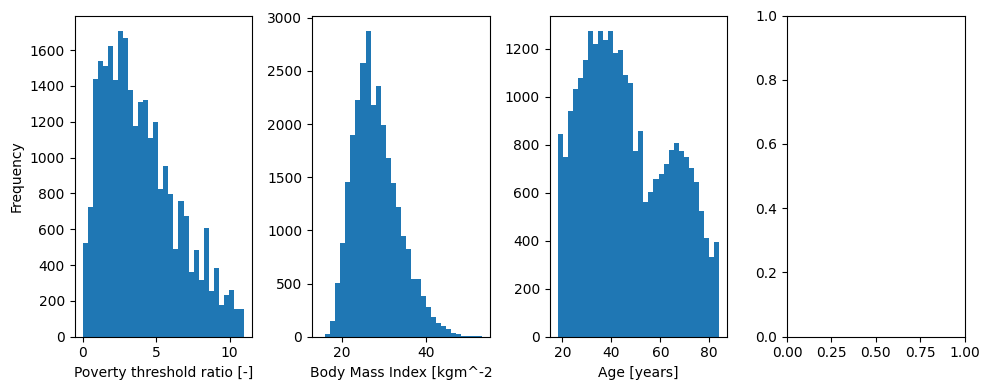

In [8]:
fig, axs = plt.subplots(1, 4, figsize=(10, 4))
axs[0].hist(df["poverty"], bins=32)
axs[1].hist(df["bmi"], bins=32)
axs[2].hist(df["age"], bins=32)
#axs[3].hist(df["sleep"], bins=24)

axs[0].set(xlabel="Poverty threshold ratio [-]", ylabel="Frequency")
axs[1].set(xlabel="Body Mass Index [kgm^-2")
axs[2].set(xlabel="Age [years]")
# axs[3].set(xlabel="Daily sleep [hours]")

fig.tight_layout()

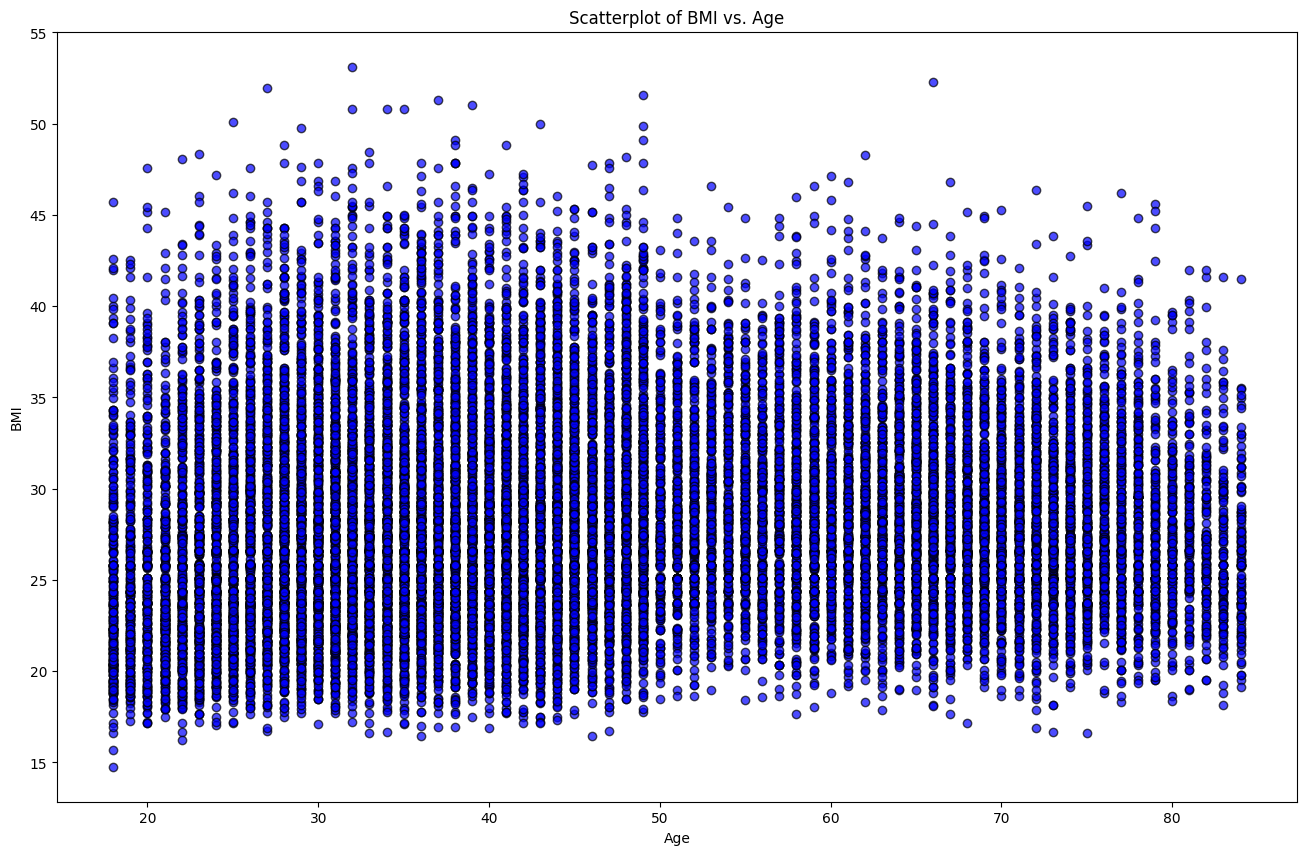

In [9]:
# Create the scatterplot
plt.figure(figsize=(16, 10))
plt.scatter(df['age'], df['bmi'], color='blue', alpha=0.7, edgecolors='black')

# Add labels and title
plt.title("Scatterplot of BMI vs. Age")
plt.xlabel("Age")
plt.ylabel("BMI")

# Show the plot
plt.show()

In [10]:
""" # Remove BMI outliers, tried and it is not good since the least satisfied group is no longer well predicted by a model
def remove_outliers_iqr(group):
    Q1 = group['bmi'].quantile(0.25)
    Q3 = group['bmi'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return group[(group['bmi'] >= lower_bound) & (group['bmi'] <= upper_bound)]

df = df.groupby('age').apply(remove_outliers_iqr).reset_index(drop=True) """

" # Remove BMI outliers, tried and it is not good since the least satisfied group is no longer well predicted by a model\ndef remove_outliers_iqr(group):\n    Q1 = group['bmi'].quantile(0.25)\n    Q3 = group['bmi'].quantile(0.75)\n    IQR = Q3 - Q1\n    lower_bound = Q1 - 1.5 * IQR\n    upper_bound = Q3 + 1.5 * IQR\n    return group[(group['bmi'] >= lower_bound) & (group['bmi'] <= upper_bound)]\n\ndf = df.groupby('age').apply(remove_outliers_iqr).reset_index(drop=True) "

In [11]:
""" # Create the scatterplot using the DataFrame columns
plt.figure(figsize=(16, 10))
plt.scatter(df['age'], df['bmi'], color='blue', alpha=0.7, edgecolors='black')

# Add labels and title
plt.title("Scatterplot of BMI vs. Age")
plt.xlabel("Age")
plt.ylabel("BMI")

# Show the plot
plt.show() """

' # Create the scatterplot using the DataFrame columns\nplt.figure(figsize=(16, 10))\nplt.scatter(df[\'age\'], df[\'bmi\'], color=\'blue\', alpha=0.7, edgecolors=\'black\')\n\n# Add labels and title\nplt.title("Scatterplot of BMI vs. Age")\nplt.xlabel("Age")\nplt.ylabel("BMI")\n\n# Show the plot\nplt.show() '

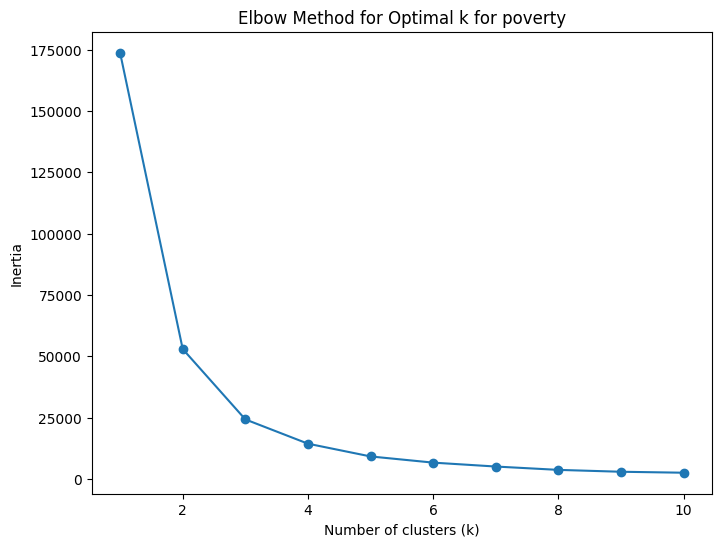

In [12]:
# Prepare the data 
poverty = df[['poverty']]

# Create an empty list to store the inertia values
inertia = []

# Test a range of k values 
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(poverty)
    inertia.append(kmeans.inertia_)

# Plot inertia vs. number of clusters (k)
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal k for poverty')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.show()

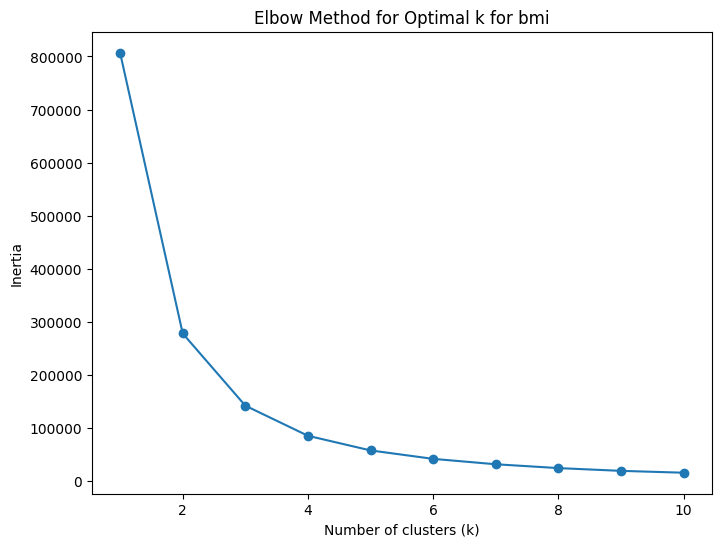

In [13]:
# Prepare the data 
bmi = df[['bmi']]

# Create an empty list to store the inertia values
inertia = []

# Test a range of k values 
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(bmi)
    inertia.append(kmeans.inertia_)

# Plot inertia vs. number of clusters (k)
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal k for bmi')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.show()

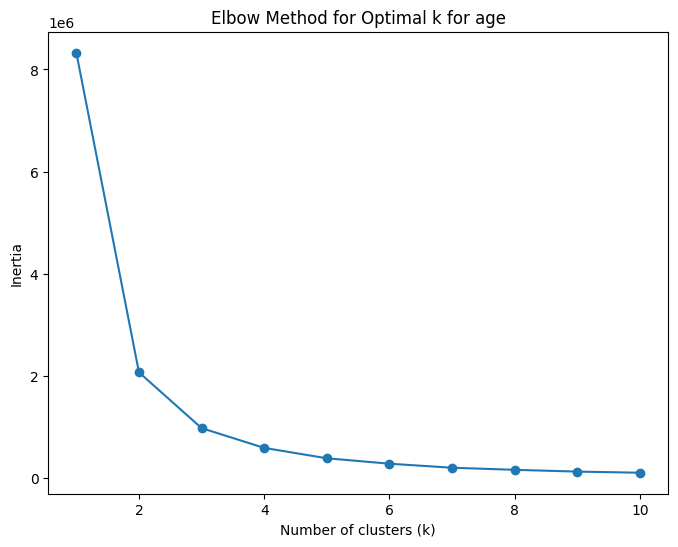

In [14]:
# Prepare the data 
age = df[['age']]

# Create an empty list to store the inertia values
inertia = []

# Test a range of k values 
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(age)
    inertia.append(kmeans.inertia_)

# Plot inertia vs. number of clusters (k)
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal k for age')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.show()

In [15]:
# Ideal k for allcontinuos data is 3 based on the elbow technique
# Apply KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
df['age_cat'] = kmeans.fit_predict(df[['age']])
df['bmi_cat'] = kmeans.fit_predict(df[['bmi']])
df['poverty_cat'] = kmeans.fit_predict(df[['poverty']])

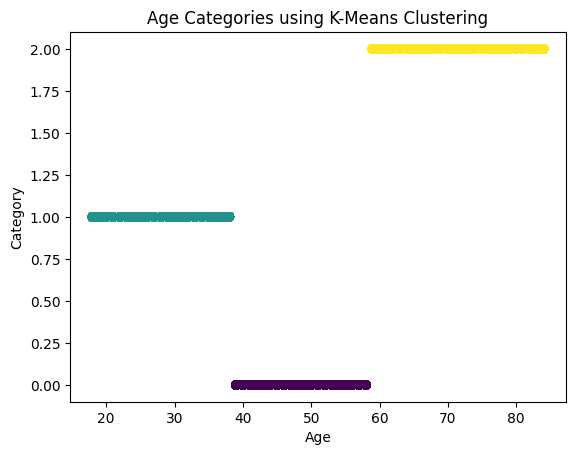

In [16]:
# Visualize the results age clustering
plt.scatter(df['age'], df['age_cat'], c=df['age_cat'], cmap='viridis')
plt.title("Age Categories using K-Means Clustering")
plt.xlabel("Age")
plt.ylabel("Category")
plt.show()

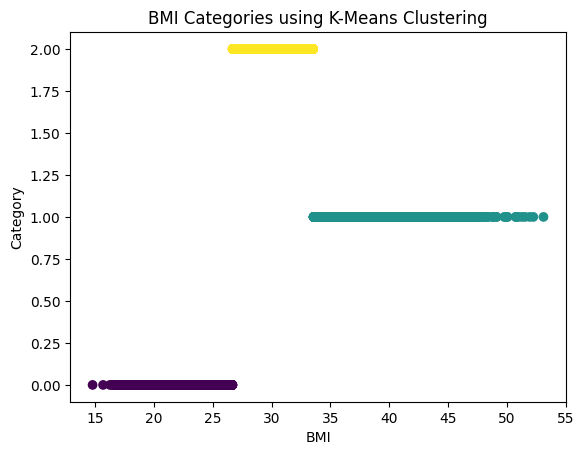

In [17]:
# Visualize the results bmi clustering
plt.scatter(df['bmi'], df['bmi_cat'], c=df['bmi_cat'], cmap='viridis')
plt.title("BMI Categories using K-Means Clustering")
plt.xlabel("BMI")
plt.ylabel("Category")
plt.show()

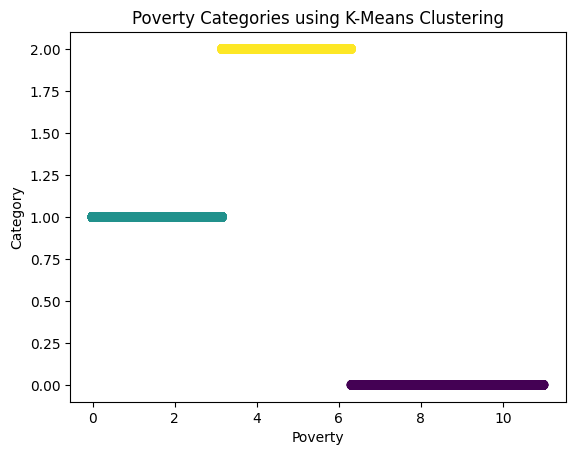

In [18]:
# Visualize the results poverty clustering
plt.scatter(df['poverty'], df['poverty_cat'], c=df['poverty_cat'], cmap='viridis')
plt.title("Poverty Categories using K-Means Clustering")
plt.xlabel("Poverty")
plt.ylabel("Category")
plt.show()

C:\Users\ssepa\AppData\Local\Temp\ipykernel_24124\3413013697.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["age"]+features)
C:\Users\ssepa\AppData\Local\Temp\ipykernel_24124\3413013697.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(["age"]+features)


parent  life_sat
False   0            7777
        1           10522
        2             798
        3             147
True    0            4121
        1            3998
        2             145
        3              39
dtype: int64

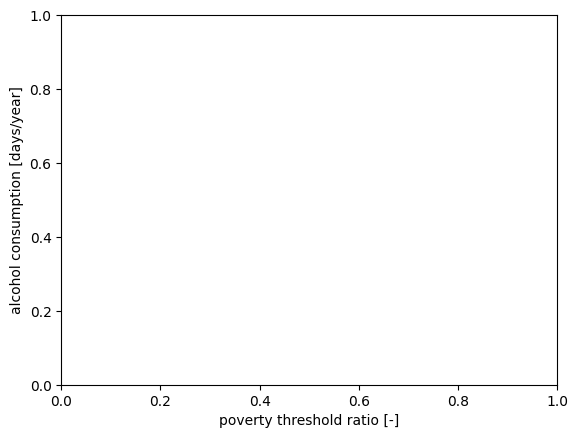

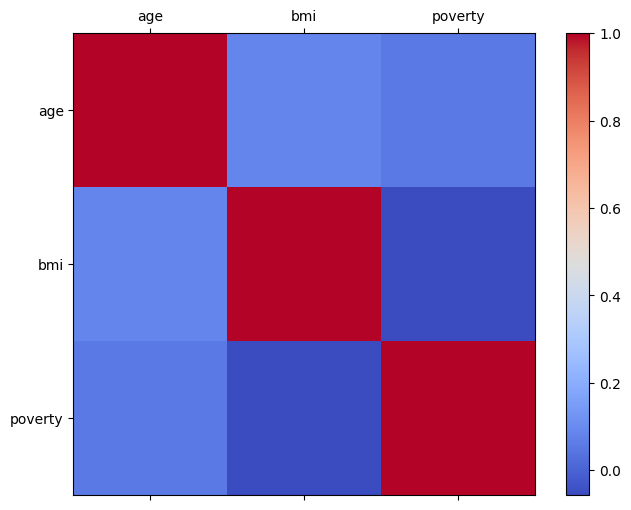

In [19]:
fig, ax = plt.subplots(1)
#ax.scatter(df["poverty"], df["alcohol"])
ax.set(xlabel="poverty threshold ratio [-]", ylabel="alcohol consumption [days/year]")


features = ["age", "bmi", "poverty"]
fig, ax = plt.subplots(1, figsize=(8, 6))
corr_matrix = df[features].corr(method="pearson")
cax = ax.matshow(corr_matrix, cmap='coolwarm')  
fig.colorbar(cax)
ax.set_xticklabels(["age"]+features)
ax.set_yticklabels(["age"]+features)
a = ["parent","life_sat"]
table = pd.crosstab(columns=[df[x] for x in a], index=df.index).sum()
table

In [20]:
df["age"] = (df["age"] - df["age"].min()) / (df["age"].max() - df["age"].min())
df["poverty"] = (df["poverty"] - df["poverty"].min()) / (df["poverty"].max() - df["poverty"].min())
df["bmi"] = (df["bmi"] - df["bmi"].min()) / (df["bmi"].max() - df["bmi"].min())
df = pd.get_dummies(df, columns=["education", "anxiety", "health_sat", "living_area", "region", "race", "age_cat", "poverty_cat", "bmi_cat"])

In [21]:
df

,weight,height,pregnant,age,gender,single,owns_home,parent,poverty,life_sat,...,race_6,age_cat_0,age_cat_1,age_cat_2,poverty_cat_0,poverty_cat_1,poverty_cat_2,bmi_cat_0,bmi_cat_1,bmi_cat_2
1,106.594120,1.8796,NaN,0.696970,0,False,0,False,0.937216,1,...,False,False,False,True,True,False,False,False,False,True
2,98.883056,1.7526,2.0,0.287879,1,False,0,False,0.851683,0,...,False,False,True,False,True,False,False,False,False,True
10,88.450440,1.7272,NaN,0.954545,0,True,0,False,0.139217,1,...,False,False,False,True,False,True,False,False,False,True
11,90.718400,1.8034,NaN,0.757576,0,True,0,False,0.328480,0,...,False,False,False,True,False,False,True,False,False,True
18,72.574720,1.7018,NaN,0.136364,0,True,1,False,0.386715,0,...,False,False,True,False,False,False,True,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29513,78.017824,1.6002,2.0,0.106061,1,True,1,False,0.289354,1,...,False,False,True,False,False,False,True,False,False,True
29514,97.522280,1.7272,2.0,0.227273,1,False,0,True,0.772520,0,...,False,False,True,False,True,False,False,False,False,True
29515,90.718400,1.8796,NaN,0.393939,0,False,0,True,0.220200,0,...,False,True,False,False,False,True,False,True,False,False
29516,97.522280,1.7526,2.0,0.409091,1,True,0,True,0.315742,0,...,False,True,False,False,False,False,True,False,False,True


In [22]:
df.columns

Index(['weight', 'height', 'pregnant', 'age', 'gender', 'single', 'owns_home',
       'parent', 'poverty', 'life_sat', 'insurance', 'cancer', 'hypertension',
       'cholesterol', 'asthma', 'bmi', 'education_1', 'education_2',
       'education_3', 'education_4', 'education_5', 'anxiety_1', 'anxiety_2',
       'anxiety_3', 'anxiety_4', 'anxiety_5', 'health_sat_1', 'health_sat_2',
       'health_sat_3', 'health_sat_4', 'health_sat_5', 'living_area_1',
       'living_area_2', 'living_area_3', 'living_area_4', 'region_1',
       'region_2', 'region_3', 'region_4', 'race_1', 'race_2', 'race_3',
       'race_4', 'race_5', 'race_6', 'age_cat_0', 'age_cat_1', 'age_cat_2',
       'poverty_cat_0', 'poverty_cat_1', 'poverty_cat_2', 'bmi_cat_0',
       'bmi_cat_1', 'bmi_cat_2'],
      dtype='object')

In [ ]:
X = df.drop(["life_sat", "pregnant", "weight", "height", "age", "bmi", "poverty"], axis=1)
y = df["life_sat"]



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

""" # reweighting
classes = np.unique(y_train)
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=y_train
)
class_weight_dict = dict(zip(classes, class_weights))
sample_weights = np.array([class_weight_dict[label] for label in y_train]) """

""" # Resample the data
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train) """

""" model = XGBClassifier(
    n_estimators=1000,       # Number of boosting rounds
    learning_rate=0.2,      # Step size shrinkage
    max_depth=6,            # Maximum depth of trees
    random_state=42,        # Random seed
) """

# Define pipeline
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),  # SMOTE for oversampling
    ('classifier', HistGradientBoostingClassifier(random_state=42))
])

# Define hyperparameter grid
param_grid = {
    'classifier__learning_rate': [0.01, 0.05, 0.1],
    'classifier__max_iter': [100, 200],
    'classifier__max_leaf_nodes': [30, 50, 100],
    'classifier__min_samples_leaf': [10, 20, 30],
    'classifier__l2_regularization': [0.0, 0.1, 0.5],
}

""" model = KNeighborsClassifier(n_neighbors=11, weights="distance") """

# Grid search
grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='f1_macro', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))


""" model.fit(X_resampled, y_resampled)
y_pred = model.predict(X_test) """

""" model = MLPClassifier(
    hidden_layer_sizes=(8, 4),  # Two hidden layers with 10 and 5 neurons
    activation='relu',           # Activation function for hidden layers
    solver='adam',               # Optimizer
    max_iter=250,                # Maximum iterations
    random_state=42              # For reproducibility    
)
model.fit(X_resampled, y_resampled)
y_pred = model.predict(X_test) """

""" print("Accuracy score:", accuracy_score(y_true=y_test, y_pred=y_pred))
print(classification_report(y_test, y_pred)) """
